In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Motivation

In many applications of Machine Learning, the goal is to classify input data into different categories or classes - e.g., predicting the cancer, recommending the product, classifying the credit default, etc. When a classifier predicts a probability, it should align with the true probability. For instance, if a classifier says there's a 20% chance of rain, then it should actually rain 20% of the time. This is called well calibrated. However, many classifiers can be poorly calibrated, meaning they may not accurately align with the true probability. This can lead to incorrect decisions which is why probability calibration is important.

Suppose a bank wants to mange the risk of default in their loan portfolio. To accomplish this, they may build a model for binary classification to classify default or not. To balance the risk and profit, bank may consider using the predicted probability of default rather than a binary one. For example, they may decline loan applications from customers with a predicted probability of default higher than 70% or they may still approve this application but with a higher interest rate depending on the risk level, which can use predicted probability as an indicator. However, it should be noted that this approach comes with the potential loss if the predicted probability is incorrect. This is where the calibration comes to play.

In [2]:
df = pd.read_csv("../data/00_enriched_data.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


(614, 19)

## Probability calibration

Luckily, most calibration techniques don't require any modification for the model. In other words, the calibration can be done out of the box, you can apply it to Neural Network, Random Forest, XGBoost, or whatever models in the shelf, as long as you can access to the predicted probability. In order to perform the calibration, there are 2 steps as follows:


* Train a calibrator using calibration set.
* When making the prediction, feed input into your model to get predicted probability then feed those into calibrator to get calibrated probability.

![](../images/probability_calibration_flow.png)

In this blog, we will focus on 2 methods: Platt's scaling, Isotonic regression.

### Platt's scaling

Platt's scaling or Logistic regression is a method of probability calibration that is used to adjust the predictions of a classifier to align with the true class probabilities. It does this by training a Logistic regression model as a calibrator, which can be represented by the following equation:

$$
P(Y|s_i) = \frac{1}{1 + e^{-(w_1 * s_i + w_2)}}
$$

Where, $s_i$ is the score output for $i^{th}$ sample, $w_1$, $w_2$ are the weights of the logistic regression. 

The goal of this method is to minimize the following loss function:

$$
\mathbb{E}[(\bar{P} - P(Y|s_i))^2]
$$

Where $\bar{p}$ is the actual probability distribution.

### Isotonic regression

Unlike Platt's scaling, an isotonic regression does not make any assumptions about the emperical distribution. It is not constrained by any functional form, as long as the function is monotonic increasing.

![](../images/isotonic_regression.png)

The isotonic regression model is trained by minimizing the same loss function as the previous method, which is $\mathbb{E}[(\bar{P} - P(Y|s_i))^2]$, where $\bar{p}$ is the actual probability distribution.

In [3]:
from modeling import encode_categorical_features, encode_categorical_features_v2, encode_all, apply_encoders, rollout_result, encode_numerical_features

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df_copy = df.dropna().copy()

In [5]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)

train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [6]:
model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [7]:
test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

In [8]:
test.reset_index(drop=True, inplace=True)

test["pred"] = model.predict(test_encoded.drop("Loan_Status", axis=1))
test["pred_prob"] = model.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1]

In [9]:
(test["Loan_Status"] == test["pred"]).mean()

0.8125

This shows the accuracy of the model is around 81%. 

### Reliability diagrams

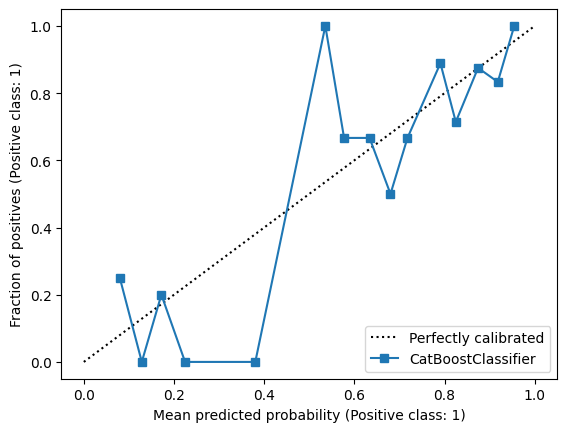

In [10]:
CalibrationDisplay.from_estimator(
    estimator=model, 
    X=test_encoded.drop("Loan_Status", axis=1), 
    y=test_encoded["Loan_Status"],
    n_bins=20
)

The figure above is a reliability diagram which shows the relationship between the model's predicted probability (x-axis) and the empirical probability (y-axis) for different quantile buckets of the data. The diagonal line represents perfect calibration, where the model's predicted probability aligns with the true probability.

Miscalibration will be recognizable as a deviation from the diagonal line that represents perfect calibration. From the result, when the model says for those who have 50% chance being class 1, 100% of them are actually class 1. This means the model is not well calibrated as the predicted probability mismatch with the true probability.

In [11]:
true_prob, est_prob = calibration_curve(
    test_encoded["Loan_Status"], 
    model.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1],
    n_bins=20
)

In [12]:
np.abs(true_prob - est_prob).sum()

2.0892039911831164

The above number is the total absolute mismatch. 

### Calibrate the model

Time to calibrate the model, we will use isotonic regression as a calibrator. Scikit-learn provides the module to do all of these for us already `CalibratedClassifierCV`. Where `method='sigmoid'` will perform Platt's scaling and `method='isotonic'` will perform isotonic regression.

In [13]:
calibrator = CalibratedClassifierCV(model, method="isotonic", ensemble=False)
calibrator.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

CalibratedClassifierCV(ensemble=False,
                       estimator=<catboost.core.CatBoostClassifier object at 0x17aba7d30>,
                       method='isotonic')

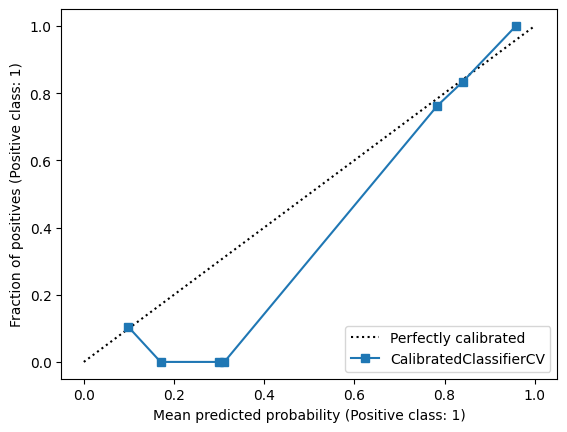

In [14]:
CalibrationDisplay.from_estimator(
    estimator=calibrator, 
    X=test_encoded.drop("Loan_Status", axis=1), 
    y=test_encoded["Loan_Status"],
    n_bins=20
)

This shows that a well-calibrated model can estimate the actual probability more accurately. It can be seen that the predicted probability aligns closely with the true probability.

In [15]:
test["pred_calibrated"] = calibrator.predict(test_encoded.drop("Loan_Status", axis=1))
test["pred_calibrated_prob"] = calibrator.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1]

In [16]:
(test["Loan_Status"] == test["pred_calibrated"]).mean()

0.8125

This shows that the accuracy after calibration won't change the performance of the model.

In [17]:
true_prob, est_prob = calibration_curve(
    test_encoded["Loan_Status"], 
    calibrator.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1],
    n_bins=20
)

In [18]:
np.abs(true_prob - est_prob).sum()

0.8581835443466215

Resulting, the calibrated model can estimate the actual probability 2x better. This means that the calibrated model can provide more accurate predictions and therefore, can improve the decision-making process.

In summary, probability calibration techniques are used to adjust the predictions of the classifier to better align with the true class probabilities. This allows for more accurate predictions, which can improve the decision-making process. While it does not affect the performance metrics of the model (accuracy, f1-score, etc.), it helps the model to estimate the probability more accurately.

It is important to note that well-calibrated model is ideal, it is not always possible to achieve perfect calibration, and some deviation may still be acceptable depending on the use case and desired level of accuracy.

# References

1. [Scikit-learn: Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)
2. [An introduction to calibration (part II): Platt scaling, isotonic regression, and beta calibration](https://www.abzu.ai/tech-blog/calibration-introduction-part-2/)
3. [Why model calibration matters and how to achieve it](https://unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)
4. [Isotonic Regression](https://en.wikipedia.org/wiki/Isotonic_regression)
5. [Are Model Predictions Probabilities?](https://pair.withgoogle.com/explorables/uncertainty-calibration/)